<a href="https://colab.research.google.com/github/lanzalibre/cold_start/blob/main/notebooks/56_fine_tune_segformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This guide shows how you can fine-tune Segformer, a state-of-the-art semantic segmentation model. Our goal is to build a model for a pizza delivery robot, so it can see where to drive and recognize obstacles 🍕🤖. We'll first label a set of sidewalk images on [Segments.ai](https://segments.ai?utm_source=hf&utm_medium=colab&utm_campaign=sem_seg). Then we'll fine-tune a pre-trained SegFormer model by using [`🤗 transformers`](https://huggingface.co/transformers), an open-source library that offers easy-to-use implementations of state-of-the-art models. Along the way, you'll learn how to work with the Hugging Face hub, the largest open-source catalog of models and datasets.**

Semantic segmentation is the task of classifying each pixel in an image. You can see it as a more precise way of classifying an image. It has a wide range of use cases in fields such as medical imaging and autonomous driving. As an example, for our pizza delivery robot, it is important to know exactly where the sidewalk is in an image, not just whether there is a sidewalk or not.

Because semantic segmentation is a type of classification, the network architectures that are used for image classification and semantic segmentation are very similar. In 2014, [a seminal paper](https://arxiv.org/abs/1411.4038) by Long et al. used convolutional neural networks for semantic segmentation. More recently, Transformers have been used for image classification (e.g. [ViT](https://huggingface.co/blog/fine-tune-vit)), and now they're also being used for semantic segmentation, pushing the state-of-the-art further.

[SegFormer](https://arxiv.org/abs/2105.15203) is a model for semantic segmentation introduced by Xie et al in 2021. It has a hierarchical Transformer encoder that doesn't use positional encodings (in contrast to ViT) and a simple multi-layer perceptron decoder. SegFormer achieves state-of-the-art performance on multiple common datasets. Let's see how it performs for sidewalk images in our pizza delivery robot.

![Pizza robot semantic segmentation](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/56_fine_tune_segformer/pizza-scene.png)

Let's get started by installing the necessary dependencies and logging in to Hugging Face.

In [1]:
!pip install -q transformers datasets segments-ai evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.9/52.9 kB 7.0 MB/s eta 0:00:00


In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
hf_username = "santilh"

# 1. Create/choose a dataset

The first step in any ML project is assembling a good dataset. In order to train a semantic segmentation model, we need a dataset with semantic segmentation labels. We can either use an existing dataset from the Hugging Face Hub, such as [ADE20k](https://huggingface.co/datasets/scene_parse_150), or create our own dataset.

For our pizza delivery robot, we could use an existing autonomous driving dataset such as [CityScapes](https://www.cityscapes-dataset.com/) or [BDD100K](https://bdd100k.com/). However, these datasets were captured by cars driving on the road. Since our delivery robot will be driving on the sidewalk, there will be a mismatch between the images in these datasets and the data our robot will see in the real world.

We don't want our delivery robot to get confused, so we'll create our own semantic segmentation dataset using images captured on sidewalks. In the next steps, we'll show how you can label the images we captured. If you just want to use our finished labeled dataset, you can skip the "Create your own dataset" section and continue from "Use a dataset from the Hub".

## Create your own dataset


To create your own semantic segmentation dataset, you'll need two things: 1) images covering the situations your model will encounter in the real world, 2) segmentation labels, i.e. images where each pixel represents a class/category.

We went ahead and captured a thousand images of sidewalks in Belgium. Collecting and labeling such a dataset can take a long time, so you can also start with a smaller dataset, and expand it if the model does not perform well enough.

![Sidewalk examples](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/56_fine_tune_segformer/sidewalk-examples.png)

To obtain segmentation labels, we need to indicate the classes of all the regions/objects in these images. This can be a time-consuming endeavour, but using the right tools can speed up the task significantly. For labeling, we'll use [Segments.ai](https://segments.ai?utm_source=hf&utm_medium=colab&utm_campaign=sem_seg), since it has smart labeling tools for image segmentation, and an easy-to-use Python SDK.

### Set up the labeling task on Segments.ai

First, create an account at [https://segments.ai/join](https://segments.ai/join?utm_source=hf&utm_medium=colab&utm_campaign=sem_seg). Next, you can create a dataset by using the web interface, or via the Python SDK. Here, we'll show how you can create a dataset programmatically.

We'll start by initializing the Segments.ai client using an API key. This key can be found on [the account page](https://segments.ai/account).

In [ ]:
from segments import SegmentsClient
from getpass import getpass

api_key = getpass('Enter your API key: ')
segments_client = SegmentsClient(api_key)

Next, we'll create a new dataset by choosing a name and by listing the different categories we want to label.

In [ ]:
dataset_name = "sidewalk-imagery"

The next cell contains the `task_attributes` with the categories we want to label. The format for `task_attributes` is defined in the [docs](https://docs.segments.ai/reference/categories-and-task-attributes).

In [ ]:
#@title `task_attributes = {...}`

task_attributes = {
 "format_version": "0.1",
 "categories": [
  {
   "name": "flat-road",
   "id": 1,
   "color": [
    216,
    82,
    24,
    255
   ],
   "attributes": []
  },
  {
   "name": "flat-sidewalk",
   "id": 2,
   "color": [
    255,
    255,
    0
   ],
   "attributes": []
  },
  {
   "name": "flat-crosswalk",
   "id": 3,
   "color": [
    125,
    46,
    141,
    255
   ],
   "attributes": []
  },
  {
   "name": "flat-cyclinglane",
   "id": 4,
   "color": [
    118,
    171,
    47,
    255
   ],
   "attributes": []
  },
  {
   "name": "flat-parkingdriveway",
   "id": 5,
   "color": [
    161,
    19,
    46,
    255
   ],
   "attributes": []
  },
  {
   "name": "flat-railtrack",
   "id": 6,
   "color": [
    255,
    0,
    0,
    255
   ],
   "attributes": []
  },
  {
   "name": "flat-curb",
   "id": 7,
   "color": [
    0,
    128,
    128
   ],
   "attributes": []
  },
  {
   "name": "human-person",
   "id": 8,
   "attributes": [
    {
     "name": "is_crowd",
     "input_type": "checkbox",
     "default_value": False
    }
   ],
   "color": [
    190,
    190,
    0,
    255
   ]
  },
  {
   "name": "human-rider",
   "id": 9,
   "attributes": [
    {
     "name": "is_crowd",
     "input_type": "checkbox",
     "default_value": False
    }
   ],
   "color": [
    0,
    255,
    0,
    255
   ]
  },
  {
   "name": "vehicle-car",
   "id": 10,
   "attributes": [
    {
     "name": "is_crowd",
     "input_type": "checkbox",
     "default_value": False
    }
   ],
   "color": [
    0,
    0,
    255,
    255
   ]
  },
  {
   "name": "vehicle-truck",
   "id": 11,
   "attributes": [
    {
     "name": "is_crowd",
     "input_type": "checkbox",
     "default_value": False
    }
   ],
   "color": [
    170,
    0,
    255,
    255
   ]
  },
  {
   "name": "vehicle-bus",
   "id": 12,
   "attributes": [
    {
     "name": "is_crowd",
     "input_type": "checkbox",
     "default_value": False
    }
   ],
   "color": [
    84,
    84,
    0,
    255
   ]
  },
  {
   "name": "vehicle-tramtrain",
   "id": 13,
   "attributes": [
    {
     "name": "is_crowd",
     "input_type": "checkbox",
     "default_value": False
    }
   ],
   "color": [
    84,
    170,
    0,
    255
   ]
  },
  {
   "name": "vehicle-motorcycle",
   "id": 14,
   "attributes": [
    {
     "name": "is_crowd",
     "input_type": "checkbox",
     "default_value": False
    }
   ],
   "color": [
    84,
    255,
    0,
    255
   ]
  },
  {
   "name": "vehicle-bicycle",
   "id": 15,
   "attributes": [
    {
     "name": "is_crowd",
     "input_type": "checkbox",
     "default_value": False
    }
   ],
   "color": [
    170,
    84,
    0,
    255
   ]
  },
  {
   "name": "vehicle-caravan",
   "id": 16,
   "attributes": [
    {
     "name": "is_crowd",
     "input_type": "checkbox",
     "default_value": False
    }
   ],
   "color": [
    170,
    170,
    0,
    255
   ]
  },
  {
   "name": "vehicle-cartrailer",
   "id": 17,
   "attributes": [
    {
     "name": "is_crowd",
     "input_type": "checkbox",
     "default_value": False
    }
   ],
   "color": [
    170,
    255,
    0,
    255
   ]
  },
  {
   "name": "construction-building",
   "id": 18,
   "color": [
    255,
    84,
    0,
    255
   ],
   "attributes": []
  },
  {
   "name": "construction-door",
   "id": 19,
   "color": [
    255,
    170,
    0,
    255
   ],
   "attributes": []
  },
  {
   "name": "construction-wall",
   "id": 20,
   "color": [
    255,
    255,
    0,
    255
   ],
   "attributes": []
  },
  {
   "name": "construction-fenceguardrail",
   "id": 21,
   "color": [
    33,
    138,
    200
   ],
   "attributes": []
  },
  {
   "name": "construction-bridge",
   "id": 22,
   "color": [
    0,
    170,
    127,
    255
   ],
   "attributes": []
  },
  {
   "name": "construction-tunnel",
   "id": 23,
   "color": [
    0,
    255,
    127,
    255
   ],
   "attributes": []
  },
  {
   "name": "construction-stairs",
   "id": 24,
   "color": [
    84,
    0,
    127,
    255
   ],
   "attributes": []
  },
  {
   "name": "object-pole",
   "id": 25,
   "attributes": [
    {
     "name": "is_crowd",
     "input_type": "checkbox",
     "default_value": False
    }
   ],
   "color": [
    84,
    84,
    127,
    255
   ]
  },
  {
   "name": "object-trafficsign",
   "id": 26,
   "color": [
    84,
    170,
    127,
    255
   ],
   "attributes": []
  },
  {
   "name": "object-trafficlight",
   "id": 27,
   "color": [
    84,
    255,
    127,
    255
   ],
   "attributes": []
  },
  {
   "name": "nature-vegetation",
   "id": 28,
   "color": [
    170,
    0,
    127,
    255
   ],
   "attributes": []
  },
  {
   "name": "nature-terrain",
   "id": 29,
   "color": [
    170,
    84,
    127,
    255
   ],
   "attributes": []
  },
  {
   "name": "sky",
   "id": 30,
   "color": [
    170,
    170,
    127,
    255
   ],
   "attributes": []
  },
  {
   "name": "void-ground",
   "id": 31,
   "color": [
    170,
    255,
    127,
    255
   ],
   "attributes": []
  },
  {
   "name": "void-dynamic",
   "id": 32,
   "color": [
    255,
    0,
    127,
    255
   ],
   "attributes": []
  },
  {
   "name": "void-static",
   "id": 33,
   "color": [
    255,
    84,
    127,
    255
   ],
   "attributes": []
  },
  {
   "name": "void-unclear",
   "id": 34,
   "color": [
    255,
    170,
    127,
    255
   ],
   "attributes": []
  }
 ]
}

In [ ]:
dataset_response = segments_client.add_dataset(dataset_name, task_attributes=task_attributes, category='street_scenery')
dataset_identifier = f'{dataset_response.owner.username}/{dataset_name}'

Now we can add images to the dataset. As an example, we'll add 10 examples images from the sidewalk dataset using `segments_client.add_sample()`.

In [ ]:
#@title `sample_attributes = [...]`

sample_attributes = [
    {
        "image": {
            "url": "https://segmentsai-prod.s3.eu-west-2.amazonaws.com/assets/tobias/72939ba9-8488-4dfe-81a2-1a299f2e1d95.jpg"
        }
    },
    {
        "image": {
            "url": "https://segmentsai-prod.s3.eu-west-2.amazonaws.com/assets/tobias/6ef02d5d-e7e4-40f6-b65a-47dee4815e7a.jpg"
        }
    },
    {
        "image": {
            "url": "https://segmentsai-prod.s3.eu-west-2.amazonaws.com/assets/tobias/46216c90-7af9-4e06-af28-4a0734a1e3a2.jpg"
        }
    },
    {
        "image": {
            "url": "https://segmentsai-prod.s3.eu-west-2.amazonaws.com/assets/tobias/545a233e-4413-4b35-9e89-659be3550ddf.jpg"
        }
    },
    {
        "image": {
            "url": "https://segmentsai-prod.s3.eu-west-2.amazonaws.com/assets/tobias/3c0ef45e-6be6-48f3-b3cd-eb283ca3cb34.jpg"
        }
    },
    {
        "image": {
            "url": "https://segmentsai-prod.s3.eu-west-2.amazonaws.com/assets/tobias/8683e29d-3112-4dff-9a64-c699bc6e1457.jpg"
        }
    },
    {
        "image": {
            "url": "https://segmentsai-prod.s3.eu-west-2.amazonaws.com/assets/tobias/83ffe351-68ea-4730-b49c-4e6945ab5c18.jpg"
        }
    },
    {
        "image": {
            "url": "https://segmentsai-prod.s3.eu-west-2.amazonaws.com/assets/tobias/653e6961-d2fa-4c1f-b450-9615707372ed.jpg"
        }
    },
    {
        "image": {
            "url": "https://segmentsai-prod.s3.eu-west-2.amazonaws.com/assets/tobias/5ee54f18-f528-40dd-83a6-92ac4771fe75.jpg"
        }
    },
    {
        "image": {
            "url": "https://segmentsai-prod.s3.eu-west-2.amazonaws.com/assets/tobias/54b0f15a-271e-4b0c-962f-23bbf179c554.jpg"
        }
    },
]

In [ ]:
for attributes in sample_attributes:
  name = attributes['image']['url'].split('/')[-1]
  segments_client.add_sample(dataset_identifier, name, attributes)

If you don't have URLs for the images you want to upload, you can use `segments_client.upload_asset()` first, see [this example](https://docs.segments.ai/reference/python-sdk#upload-a-file-as-an-asset).

Alternatively, you can also drag and drop your files to the Samples tab of your dataset.

### Label the images

Now that the raw data is loaded, go to [segments.ai/home](https://segments.ai/home) and open the newly created dataset. Click "Start labeling" and create segmentation masks. You can use the ML-powered superpixel and autosegment tools to label faster.

![Labeling](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/56_fine_tune_segformer/sidewalk-labeling-crop.gif)

*Tip: when using the superpixel tool, scroll to change the superpixel size, and click and drag to select segments.*

### Push the result to the Hugging Face Hub

When you're done labeling, create a new dataset release containing the labeled data. You can either do this on the releases tab on Segments.ai, or programmatically through the SDK as shown below.

Note that creating the release can take a few seconds. You can check the releases tab on Segments.ai to check if your release is still being created.

In [ ]:
release_name = "v0.1"

segments_client.add_release(dataset_identifier, release_name)

Now, we'll use the `release2dataset` function to convert our release to a [Hugging Face dataset](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset). This can take a while, depending on the size of your dataset.

In [ ]:
from segments.huggingface import release2dataset

release = segments_client.get_release(dataset_identifier, release_name)
hf_dataset = release2dataset(release)

In [ ]:
hf_dataset.features

If we inspect the features of the new dataset, we can see the image column and the corresponding label. The label consists of two parts: a list of annotations and a segmentation bitmap. The annotation corresponds to the different objects in the image. For each object, the annotation contains an `id` and a `category_id`. The segmentation bitmap is an image where each pixel contains the `id` of the object at that pixel. More information can be found in the [relevant docs](https://docs.segments.ai/reference/sample-and-label-types/label-types#segmentation-labels).

For semantic segmentation, we need a semantic bitmap with a `category_id` for each pixel. We'll use the `get_semantic_bitmap` function from the Segments.ai SDK to convert the bitmaps to semantic bitmaps. In order to apply this function to all the rows in our dataset, we'll use [`dataset.map`](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.map).

In [ ]:
from segments.utils import get_semantic_bitmap


def convert_segmentation_bitmap(example):
    return {
        "label.segmentation_bitmap":
            get_semantic_bitmap(
                example["label.segmentation_bitmap"],
                example["label.annotations"],
            )
    }


semantic_dataset = hf_dataset.map(
    convert_segmentation_bitmap,
)


You can also rewrite the `convert_segmentation_bitmap` function to use batches and pass `batched=True` to `dataset.map`. This will speed up the mapping significantly, but you might need to tweak the `batch_size` to make sure the process doesn't run out of memory.

The SegFormer model we're going to fine-tune later expects certain names for the features. For convenience, we'll already match this format now. Thus, we'll rename the `image` feature to `pixel_values`, the `label.segmentation_bitmap` to `label` and discard the other features.

In [ ]:
semantic_dataset = semantic_dataset.rename_column('image', 'pixel_values')
semantic_dataset = semantic_dataset.rename_column('label.segmentation_bitmap', 'label')
semantic_dataset = semantic_dataset.remove_columns(['name', 'uuid', 'status', 'label.annotations'])

In [ ]:
semantic_dataset.features

We can now push the transformed dataset to the Hugging Face Hub. That way, your team and the Hugging Face community can make use of it. In the next section, we'll see how you can load the dataset from the hub.

In [ ]:
hf_dataset_identifier = f"{hf_username}/{dataset_name}"

semantic_dataset.push_to_hub(hf_dataset_identifier)

## Use a dataset from the Hub

If you don't want to create your own dataset, but found a suitable dataset for your use case on the Hugging Face Hub, you can define the identifier here.

For example, you can use the full labeled sidewalk dataset. Note that you can check out the examples [directly in your browser](https://huggingface.co/datasets/segments/sidewalk-semantic).

In [5]:
hf_dataset_identifier = "segments/sidewalk-semantic"

# 2. Load and prepare the Hugging Face dataset for training

Now that we've created a new dataset and pushed it to the Hugging Face Hub, we can load the dataset in a single line.

In [6]:
from datasets import load_dataset

ds = load_dataset(hf_dataset_identifier)

ModuleNotFoundError: No module named 'datasets'

Let's shuffle the dataset and split the dataset in a train and test set.

In [7]:
ds = ds.shuffle(seed=1)
ds = ds["train"].train_test_split(test_size=0.2)
train_ds = ds["train"]
test_ds = ds["test"]

We'll extract the number of labels and the human-readable ids, so we can configure the segmentation model correctly later on.

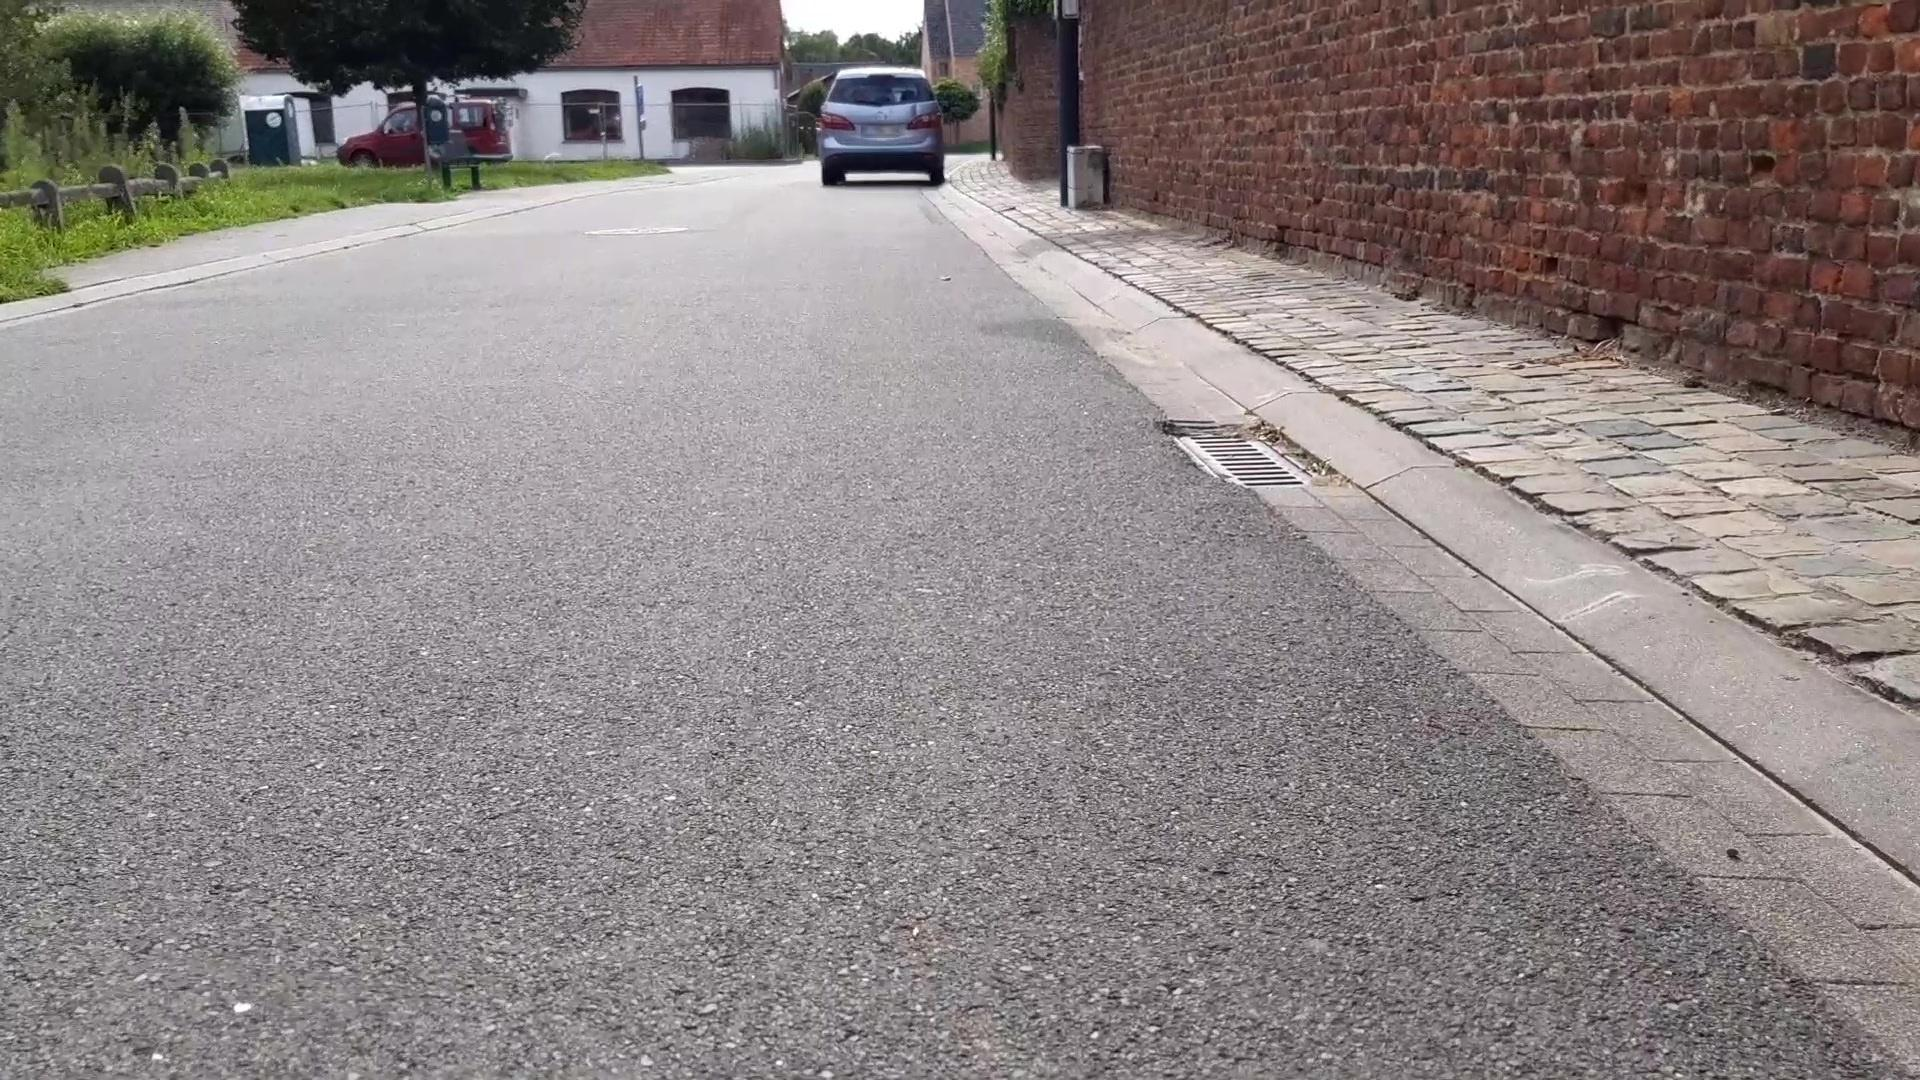

In [8]:
image = test_ds[0]['pixel_values']
gt_seg = test_ds[0]['label']
image

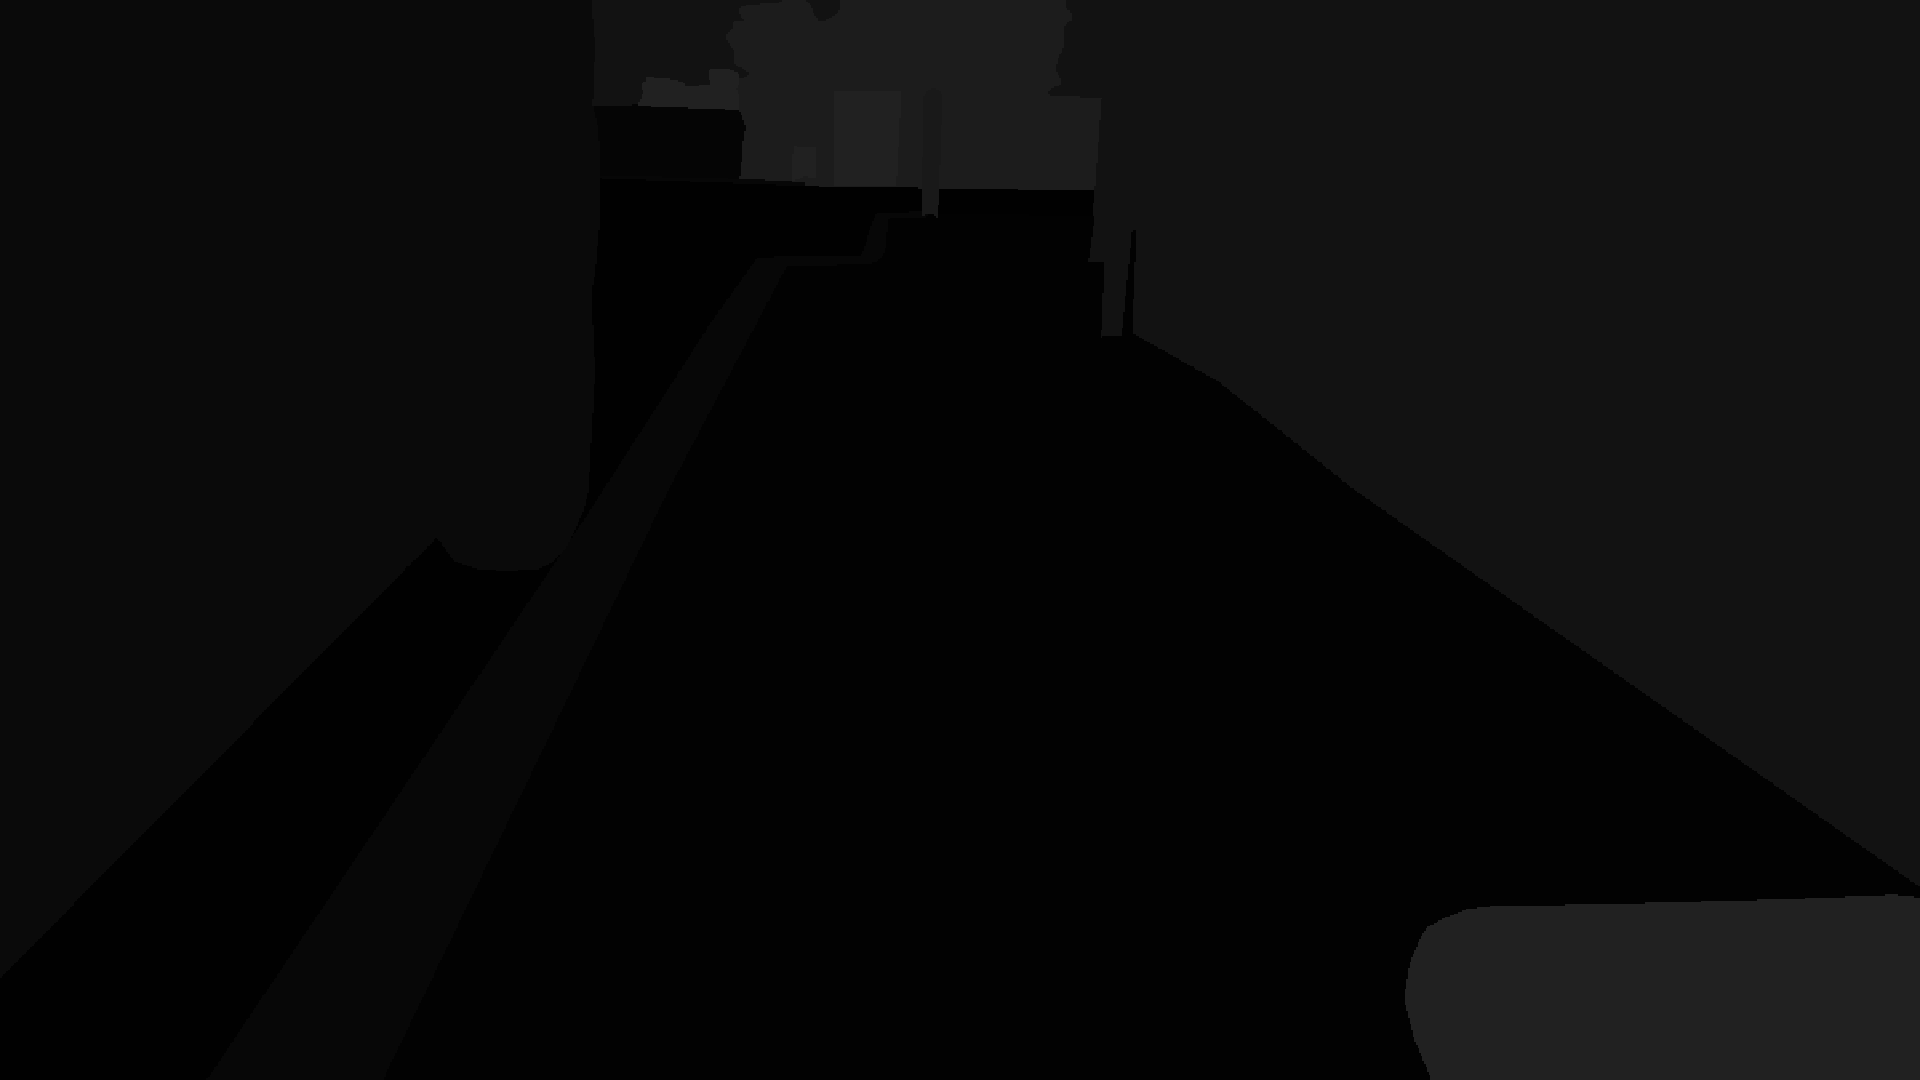

In [16]:
gt_seg

In [9]:
import json
from huggingface_hub import hf_hub_download

filename = "id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)
print("Id2label:", id2label)

## Image processor & data augmentation

A SegFormer model expects the input to be of a certain shape. To transform our training data to match the expected shape, we can use `SegFormerImageProcessor`. We could use the `ds.map` function to apply the image processor to the whole training dataset in advance, but this can take up a lot of disk space. Instead, we'll use a *transform*, which will only prepare a batch of data when that data is actually used (on-the-fly). This way, we can start training without waiting for further data preprocessing.

In our transform, we'll also define some data augmentations to make our model more resilient to different lighting conditions. We'll use the [`ColorJitter`](https://pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html) function from `torchvision` to randomly change the brightness, contrast, saturation, and hue of the images in the batch.

In [10]:
from torchvision.transforms import ColorJitter
from transformers import (
    SegformerImageProcessor,
)

processor = SegformerImageProcessor()
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = processor(images, labels)
    return inputs


def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = processor(images, labels)
    return inputs


# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

# 3. Fine-tune a SegFormer model

## Load the model to fine-tune

The SegFormer authors define 5 models with increasing sizes: B0 to B5. The following chart (taken from the original paper) shows the performance of these different models on the ADE20K dataset, compared to other models.

![Segmentation model comparison](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/56_fine_tune_segformer/segformer.png)

Here, we'll load the smallest SegFormer model (B0), pre-trained on ImageNet-1k. It's only about 14MB in size!

Using a small model will make sure that our model can run smoothly on our pizza delivery robot.

In [11]:
from transformers import SegformerForSemanticSegmentation

pretrained_model_name = "nvidia/mit-b0"
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Set up the Trainer

To fine-tune the model on our data, we'll use Hugging Face's [Trainer API](https://huggingface.co/docs/transformers/main_classes/trainer). In order to use a Trainer, we need to set up the training configuration, and an evalutation metric.

First, we'll set up the [`TrainingArguments`](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments). This defines all training hyperparameters, such as learning rate and the number of epochs, frequency to save the model and so on. We also specify to push the model to the hub after training (`push_to_hub=True`) and specify a model name (`hub_model_id`).

In [21]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [23]:
!pip install accelerate -U

In [25]:
! pip install -U transformers

In [12]:
from transformers import TrainingArguments

epochs = 50
lr = 0.00006
batch_size = 2

hub_model_id = "segformer-b0-finetuned-segments-sidewalk-oct-22"

training_args = TrainingArguments(
    "segformer-b0-finetuned-segments-sidewalk-outputs",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id=hub_model_id,
    hub_strategy="end",
)

Next, we'll define a function that computes the evaluation metric we want to work with. Because we're doing semantic segmentation, we'll use the mean Intersection over Union (mIoU), directly accessible in the `datasets` library (see [here](https://huggingface.co/metrics/mean_iou)). IoU represents the overlap of segmentation masks. Mean IoU is the average of the IoU of all semantic classes. Take a look at [this blogpost](https://www.jeremyjordan.me/evaluating-image-segmentation-models/) for an overview of evaluation metrics for image segmentation.

Because our model outputs logits with dimensions height/4 and width/4, we have to upscale them before we can compute the mIoU.

In [13]:
import torch
from torch import nn
import evaluate
import multiprocessing

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    pred_labels = logits_tensor.detach().cpu().numpy()
    metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=processor.do_reduce_labels,
        )

    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    return metrics

Finally, we can instantiate a `Trainer` object.

In [14]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Now that our trainer is set up, training is as simple as calling the `train` function. We don't need to worry about managing our GPU(s), the trainer will take care of that.

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Accuracy Unlabeled,Accuracy Flat-road,Accuracy Flat-sidewalk,Accuracy Flat-crosswalk,Accuracy Flat-cyclinglane,Accuracy Flat-parkingdriveway,Accuracy Flat-railtrack,Accuracy Flat-curb,Accuracy Human-person,Accuracy Human-rider,Accuracy Vehicle-car,Accuracy Vehicle-truck,Accuracy Vehicle-bus,Accuracy Vehicle-tramtrain,Accuracy Vehicle-motorcycle,Accuracy Vehicle-bicycle,Accuracy Vehicle-caravan,Accuracy Vehicle-cartrailer,Accuracy Construction-building,Accuracy Construction-door,Accuracy Construction-wall,Accuracy Construction-fenceguardrail,Accuracy Construction-bridge,Accuracy Construction-tunnel,Accuracy Construction-stairs,Accuracy Object-pole,Accuracy Object-trafficsign,Accuracy Object-trafficlight,Accuracy Nature-vegetation,Accuracy Nature-terrain,Accuracy Sky,Accuracy Void-ground,Accuracy Void-dynamic,Accuracy Void-static,Accuracy Void-unclear,Iou Unlabeled,Iou Flat-road,Iou Flat-sidewalk,Iou Flat-crosswalk,Iou Flat-cyclinglane,Iou Flat-parkingdriveway,Iou Flat-railtrack,Iou Flat-curb,Iou Human-person,Iou Human-rider,Iou Vehicle-car,Iou Vehicle-truck,Iou Vehicle-bus,Iou Vehicle-tramtrain,Iou Vehicle-motorcycle,Iou Vehicle-bicycle,Iou Vehicle-caravan,Iou Vehicle-cartrailer,Iou Construction-building,Iou Construction-door,Iou Construction-wall,Iou Construction-fenceguardrail,Iou Construction-bridge,Iou Construction-tunnel,Iou Construction-stairs,Iou Object-pole,Iou Object-trafficsign,Iou Object-trafficlight,Iou Nature-vegetation,Iou Nature-terrain,Iou Sky,Iou Void-ground,Iou Void-dynamic,Iou Void-static,Iou Void-unclear
20,2.852700,3.210491,0.066733,0.114104,0.565792,nan,0.199515,0.926617,0.000000,0.339806,0.000000,nan,0.007394,0.000137,0.000000,0.785772,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.282653,0.000000,0.000087,0.003180,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.991236,0.002287,0.089297,0.000000,0.021033,0.002326,0.000000,0.000000,0.189942,0.645333,0.000000,0.241347,0.000000,nan,0.006699,0.000133,0.000000,0.401672,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.240868,0.000000,0.000087,0.002896,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.430203,0.002219,0.088824,0.000000,0.016437,0.002252,0.000000
40,2.788100,2.423380,0.083215,0.133366,0.607627,nan,0.582970,0.894829,0.000000,0.030561,0.000000,nan,0.000719,0.000000,0.000000,0.877548,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.431872,0.000000,0.000010,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.986427,0.000239,0.462523,0.000000,0.000000,0.000000,0.000000,nan,0.393578,0.687422,0.000000,0.029950,0.000000,nan,0.000716,0.000000,0.000000,0.337206,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.342859,0.000000,0.000010,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.497454,0.000238,0.456676,0.000000,0.000000,0.000000,0.000000
60,2.262800,1.941031,0.096475,0.148737,0.641975,nan,0.658146,0.904842,0.000000,0.027341,0.000000,nan,0.000618,0.000000,0.000000,0.959666,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.633082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.952327,0.003049,0.620513,0.000000,0.000000,0.000000,0.000000,nan,0.408518,0.696359,0.000000,0.026851,0.000000,nan,0.000616,0.000000,0.000000,0.393075,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.452168,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.597187,0.003020,0.605885,0.000000,0.000000,0.000000,0.000000
80,2.895200,1.817693,0.106996,0.154640,0.662545,nan,0.645465,0.932669,0.000000,0.060814,0.000000,nan,0.000018,0.000000,0.000000,0.927475,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.699255,0.000000,0.000337,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.974960,0.005111,0.702381,0.000000,0.000000,0.000000,0.000000,nan,0.434551,0.720549,0.000000,0.059999,0.000000,nan,0.000018,0.

/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encoun

When we're done with training, we can push our fine-tuned model and the image processor to the Hugging Face hub.

This will also automatically create a model card with our results. We'll supply some extra information in `kwargs` to make the model card more complete.

In [1]:
kwargs = {
    "tags": ["vision", "image-segmentation"],
    "finetuned_from": pretrained_model_name,
    "dataset": hf_dataset_identifier,
}

hub_model_id = "segformer-b0-finetuned-segments-sidewalk-slh0324"

processor.push_to_hub(hub_model_id)
trainer.push_to_hub(**kwargs)

NameError: name 'pretrained_model_name' is not defined

# 4. Inference

Now comes the exciting part, using our fine-tuned model! In this section, we'll show how you can load your model from the hub and use it for inference.

However, you can also try out your model directly on the Hugging Face Hub, thanks to the cool widgets powered by the [hosted inference API](https://api-inference.huggingface.co/docs/python/html/index.html). If you pushed your model to the hub in the previous step, you should see an inference widget on your model page. You can add default examples to the widget by defining example image URLs in your model card. See [this model card](https://huggingface.co/segments-tobias/segformer-b0-finetuned-segments-sidewalk/blob/main/README.md) as an example.

![Inference widget](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/56_fine_tune_segformer/widget-poster.png)

## Use the model from the hub

We'll first load the model from the hub using `SegformerForSemanticSegmentation.from_pretrained()`.



In [2]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained(f"{hf_username}/{hub_model_id}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


NameError: name 'hf_username' is not defined

Next, we'll load an image from our test dataset.

In [ ]:
image = test_ds[0]['pixel_values']
gt_seg = test_ds[0]['label']
image

To segment this test image, we first need to prepare the image using the image processor. Then we forward it through the model.

We also need to remember to upscale the output logits to the original image size. In order to get the actual category predictions, we just have to apply an `argmax` on the logits.

In [ ]:
from torch import nn

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1], # (height, width)
    mode='bilinear',
    align_corners=False
)

# Second, apply argmax on the class dimension
pred_seg = upsampled_logits.argmax(dim=1)[0]

Now it's time to display the result. The next cell defines the colors for each category, so that they match the "category coloring" on Segments.ai.

In [ ]:
#@title `def sidewalk_palette()`

def sidewalk_palette():
    """Sidewalk palette that maps each class to RGB values."""
    return [
        [0, 0, 0],
        [216, 82, 24],
        [255, 255, 0],
        [125, 46, 141],
        [118, 171, 47],
        [161, 19, 46],
        [255, 0, 0],
        [0, 128, 128],
        [190, 190, 0],
        [0, 255, 0],
        [0, 0, 255],
        [170, 0, 255],
        [84, 84, 0],
        [84, 170, 0],
        [84, 255, 0],
        [170, 84, 0],
        [170, 170, 0],
        [170, 255, 0],
        [255, 84, 0],
        [255, 170, 0],
        [255, 255, 0],
        [33, 138, 200],
        [0, 170, 127],
        [0, 255, 127],
        [84, 0, 127],
        [84, 84, 127],
        [84, 170, 127],
        [84, 255, 127],
        [170, 0, 127],
        [170, 84, 127],
        [170, 170, 127],
        [170, 255, 127],
        [255, 0, 127],
        [255, 84, 127],
        [255, 170, 127],
    ]

The next function overlays the output segmentation map on the original image.

In [ ]:
import numpy as np

def get_seg_overlay(image, seg):
  color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
  palette = np.array(sidewalk_palette())
  for label, color in enumerate(palette):
      color_seg[seg == label, :] = color

  # Show image + mask
  img = np.array(image) * 0.5 + color_seg * 0.5
  img = img.astype(np.uint8)

  return img

We'll display the result next to the ground-truth mask.

In [ ]:
import matplotlib.pyplot as plt

pred_img = get_seg_overlay(image, pred_seg)
gt_img = get_seg_overlay(image, np.array(gt_seg))

f, axs = plt.subplots(1, 2)
f.set_figheight(30)
f.set_figwidth(50)

axs[0].set_title("Prediction", {'fontsize': 40})
axs[0].imshow(pred_img)
axs[1].set_title("Ground truth", {'fontsize': 40})
axs[1].imshow(gt_img)

What do you think? Would you send our pizza delivery robot on the road with this segmentation information?

The result might not be perfect yet, but we can always expand our dataset to make the model more robust. We can now also go train a larger SegFormer model, and see how it stacks up.

# 5. Conclusion

That's it! You now know how to create your own image segmentation dataset and how to use it to fine-tune a semantic segmentation model.

We introduced you to some useful tools along the way, such as:


*   [Segments.ai](https://segments.ai) for labeling your data
*   [🤗 datasets](https://huggingface.co/docs/datasets/) for creating and sharing a dataset
*   [🤗 transformers](https://huggingface.co/transformers) for easily fine-tuning a state-of-the-art segmentation model
*   [🤗 hub](https://huggingface.co/docs/hub/main) for sharing our dataset and model, and for creating an inference widget for our model


We hope you enjoyed this post and learned something. Feel free to share your own model with us on Twitter ([@TobiasCornille](https://twitter.com/tobiascornille), [@NielsRogge](https://twitter.com/nielsrogge), and [@huggingface](https://twitter.com/huggingface)).